<a href="https://colab.research.google.com/github/Moe-phantom/Moe-phantom/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn, optim
from torchvision import datasets, models, transforms
from PIL import Image

import seaborn as sns


In [5]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
True


In [6]:
# imports
import os
import requests
from pathlib import Path
import tarfile

# defining dataset directory
data_dir = './flowers'

# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")

    print() # for readability

    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")
    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Directory created: ./flowers

[INFO] Downloading the file 'flower_data.tar.gz' to ./flowers
[INFO] 'flower_data.tar.gz' saved to ./flowers

[INFO] Extracting the downloaded tarball to ./flowers
[INFO] 'flower_data.tar.gz' extracted successfully to ./flowers

[INFO] Deleting the tarball to save space.


In [7]:
import json

data = {
    "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster",
    "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
    "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly",
    "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist",
    "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower",
    "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation",
    "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
    "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow",
    "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid",
    "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
    "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura",
    "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium",
    "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
    "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william",
    "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon",
    "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula",
    "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
    "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple",
    "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus",
    "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily",
    "46": "wallflower", "77": "passion flower", "51": "petunia"
}

with open('cat_to_name.json', 'w') as file:
    json.dump(data, file)

In [8]:
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

--2024-02-03 12:55:12--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.175.96, 52.217.234.120, 54.231.198.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.175.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  15.8MB/s    in 56s     

2024-02-03 12:56:09 (5.84 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

unlink: cannot unlink 'flowers': Is a directory
mkdir: cannot create directory ‘flowers’: File exists


In [9]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [42]:
# Define transforms for the training, validation, and testing sets
train_transform = transforms.Compose([transforms.RandomRotation(50),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                   [0.229, 0.224, 0.225])])

valid_transform = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 64)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64)

In [43]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)


In [ ]:
print (json.dumps(cat_to_name, indent=2))


In [ ]:
model = models.vgg16(pretrained = True)
model

In [45]:
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
          nn.Linear(25088, 512),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(256, 102),
          nn.LogSoftmax(dim = 1)
        )

model.classifier = classifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0025)

model.to(device)

In [47]:
epochs = 4
steps = 0
print_every = 10
train_loss = 0

# Note: I looked at the notebooks from the last module and decided to do it in a similar way
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            valid_accuracy = 0

            model.eval()

            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()

                    # Calculate validation accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"""Epoch no. {epoch+1}/{epochs},
            """
                  f"Train loss: {train_loss/print_every:.3f}, "
                  f"Valid loss: {valid_loss/len(validloader):.3f}, "
                  f"Valid accuracy: {valid_accuracy/len(validloader):.3f}")

            train_loss = 0

            model.train()

Epoch 1/4, Train loss: 4.841, Valid loss: 4.317, Valid accuracy: 0.087
Epoch 1/4, Train loss: 4.291, Valid loss: 3.807, Valid accuracy: 0.144
Epoch 1/4, Train loss: 3.901, Valid loss: 3.336, Valid accuracy: 0.227
Epoch 1/4, Train loss: 3.426, Valid loss: 2.824, Valid accuracy: 0.342
Epoch 1/4, Train loss: 3.080, Valid loss: 2.286, Valid accuracy: 0.432
Epoch 1/4, Train loss: 2.808, Valid loss: 2.135, Valid accuracy: 0.447
Epoch 1/4, Train loss: 2.734, Valid loss: 1.913, Valid accuracy: 0.485
Epoch 1/4, Train loss: 2.410, Valid loss: 1.552, Valid accuracy: 0.569
Epoch 1/4, Train loss: 2.476, Valid loss: 1.561, Valid accuracy: 0.554
Epoch 1/4, Train loss: 2.394, Valid loss: 1.569, Valid accuracy: 0.554
Epoch 2/4, Train loss: 2.153, Valid loss: 1.476, Valid accuracy: 0.607
Epoch 2/4, Train loss: 2.195, Valid loss: 1.461, Valid accuracy: 0.615
Epoch 2/4, Train loss: 2.004, Valid loss: 1.365, Valid accuracy: 0.645
Epoch 2/4, Train loss: 2.069, Valid loss: 1.355, Valid accuracy: 0.611
Epoch 

In [48]:
# Validation on the test set
test_loss = 0
test_accuracy = 0
model.eval() # We just want to evaluate and not train the model
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        # Calculate accuracy of test set
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(testloader):.3f}, "
      f"Test accuracy: {test_accuracy/len(testloader):.3f}")
running_loss = 0

Test loss: 0.994, Test accuracy: 0.712


In [49]:
# Saving the checkpoint

checkpoint = {
    'epochs': epochs,
    'learning_rate': 0.0025,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
    'class_to_idx': train_data.class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

In [50]:
# Loading checkpoint and rebuilding the model
def load_checkpoint(filepath):
    model = models.vgg16(pretrained = True)

    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(
          nn.Linear(25088, 512),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(256, 102),
          nn.LogSoftmax(dim = 1))

    model.classifier = classifier

    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    epochs = checkpoint['epochs']
    learning_rate = checkpoint['learning_rate']

    model.class_to_idx = checkpoint['class_to_idx']

    return model, epochs, learning_rate

In [51]:
model, epochs, learning_rate = load_checkpoint('checkpoint.pth')
model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image = Image.open(image)

    # Note: For me the simplest way was to just use the already defined transformation
    return test_transform(image)

In [59]:
import numpy as np

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes it is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.axis('off')  # Turn off axis

    if title:
        ax.set_title(title)

    return ax


<Axes: >

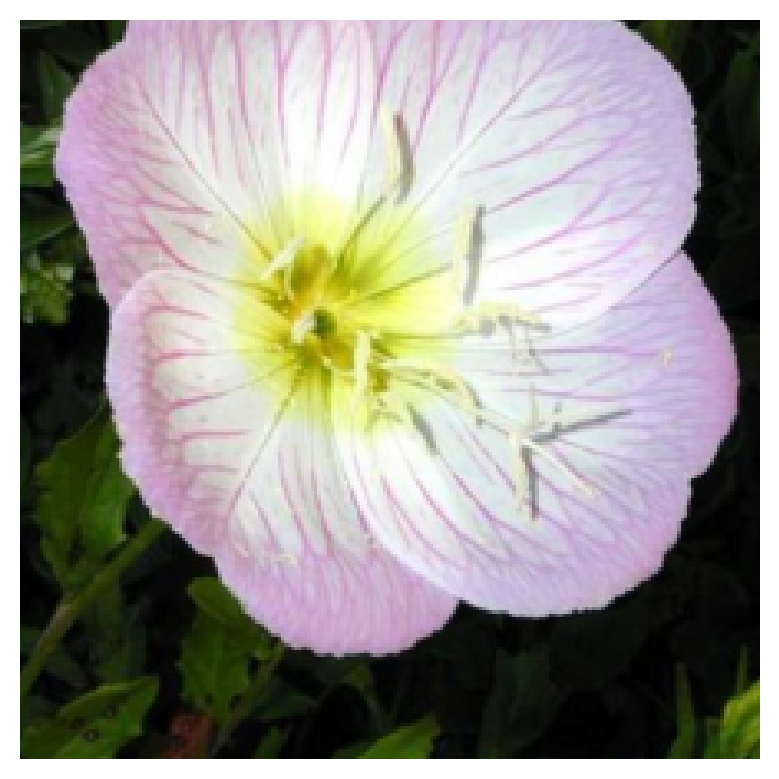

In [60]:
imshow(process_image('flowers/test/1/image_06743.jpg'))


In [61]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    model.eval()
    with torch.no_grad():
        logps = model.forward(process_image(image_path).unsqueeze(0))
        ps = torch.exp(logps)
        probs, labels = ps.topk(topk, dim=1)

        class_to_idx_inv = {model.class_to_idx[i]: i for i in model.class_to_idx}
        classes = list()

        for label in labels.numpy()[0]:
            classes.append(class_to_idx_inv[label])

        return probs.numpy()[0], classes

In [56]:
probs, classes = predict('flowers/test/15/image_06369.jpg', model)
print(probs)
print(classes)

[0.5166369  0.42178258 0.01687751 0.00580753 0.00541655]
['15', '42', '48', '90', '16']


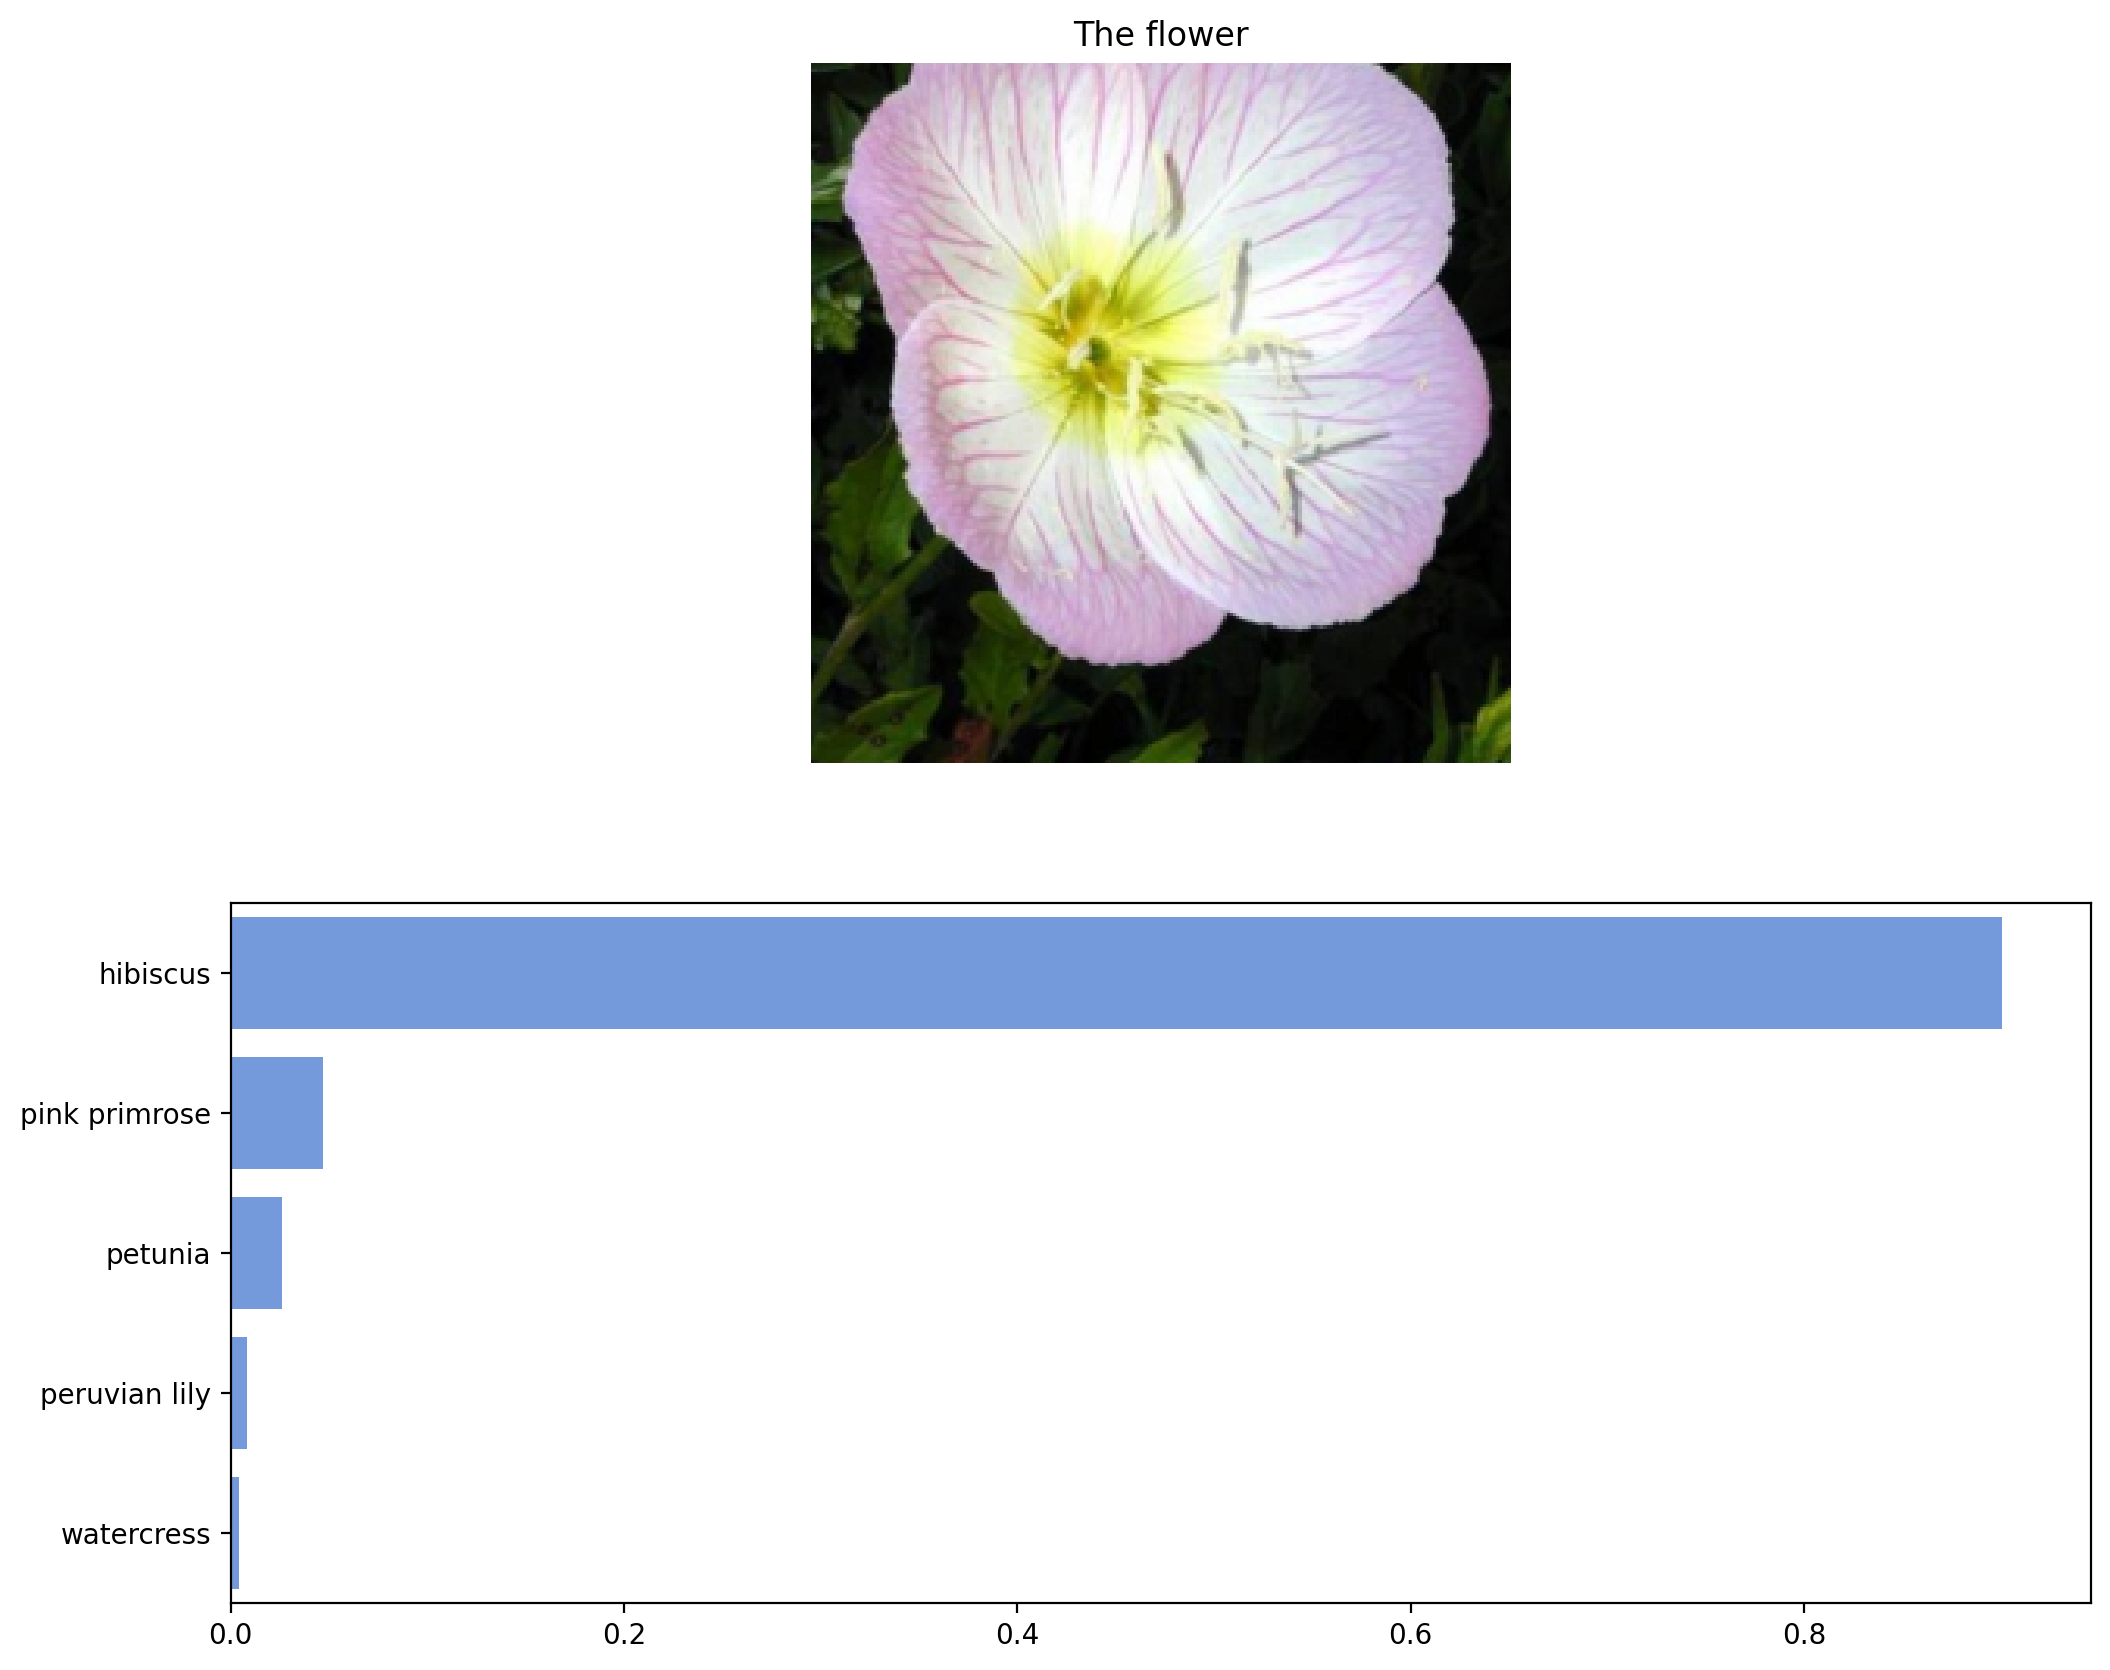

In [63]:

def visualize_prediction(image_path, image_class, model, cat_to_name):
    predict_probs, predict_classes = predict(image_path, model)

    classes = [cat_to_name[predict_class] for predict_class in predict_classes]

    # Create a subplot with 2 rows and 1 column
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plotting Image
    ax1.set_title(cat_to_name[image_class])
    ax1.axis('off')
    imshow(process_image(image_path), ax1, title="The flower")

    # Plotting probabilities
    sns.barplot(x=predict_probs, y=classes, color='cornflowerblue', ax=ax2)

    plt.show()

# Example usage:
image_path = 'flowers/test/1/image_06743.jpg'
image_class = '1'
visualize_prediction(image_path, image_class, model, cat_to_name)
